## Plots graph edit distance figures in SI.

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import matplotlib.pyplot as plt
plt.rcParams.update({'font.family':'Arial'})
import numpy as np

import re
import pandas as pd

from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import utils_3 as utils

In [3]:
def sum_abs_adj_matrix(m):
    return sum(sum(np.abs(m)))/2

In [4]:
# synthia graph colors
synthia_purple = np.array([80,50,145,255])/255
synthia_blue = np.array([45,190,205,255])/255
synthia_orange = np.array([255,160,0,255])/255
synthia_pink = np.array([235,60,150,255])/255
black = np.array([0,0,0,1])

synthia_colorset = [synthia_purple,synthia_pink,synthia_blue,synthia_orange]
synthia_pm_cmap2 = ListedColormap((synthia_purple,black,synthia_orange))

In [5]:
# chemdraw step marker colors
cdraw_orange_face = np.array([252,236,207,255])/255
cdraw_orange_edge = np.array([245,191,94,255])/255
cdraw_purple = np.array([103,103,255,255])/255
cdraw_purple_dark = np.array([140,10,237,255])/255

In [6]:
# gridline color
grid_grey = np.array([225,225,225,255])/255

## initialize

In [7]:
def get_route_stereo_score(route):
    
    scores = []
    for step_number in range(1,len(route)):
        
        make_correct_stereo, make_inverted_stereo, flip_stereo = 0,0,0
        diag_before = np.diag(route[step_number-1].copy())
        diag_after =  np.diag(route[step_number].copy())

        for i in zip(diag_before,diag_after):
            if i == (0,1):
                make_correct_stereo += 1
            if i == (0,-1):
                make_inverted_stereo += 1

            if i == (-1,1):
                flip_stereo += 1
                
        scores.append([make_correct_stereo, make_inverted_stereo, flip_stereo])
        
    return np.array(scores)
    

In [8]:
def get_route_score(route,target_atom_count,use_conns=False,as_df=False):
    
    
    stereo_score = get_route_stereo_score(route.copy())
    # use unweighted bond matrix if needed
    if use_conns:
        route = (route!=0).astype(int)
    
    amat_target = route[-1].copy()
    scores = []
    for step_number in range(1,len(route)):
        amat_before = route[step_number-1]
        amat_after = route[step_number]

        amat_change = amat_after - amat_before
        
        changing_bonds = np.where(amat_change !=0)
        anno_bonds = np.vstack(changing_bonds).T
        
        target_bonds = amat_target[changing_bonds]

        before_bonds = amat_before[changing_bonds]
        before_distance = target_bonds - before_bonds

        after_bonds = amat_after[changing_bonds]
        after_distance = target_bonds - after_bonds
        
        t_f_strat, t_f_con, t_b_strat,t_b_con,c_f_fin, c_f_con, c_b_con = 0,0,0,0,0,0,0

        for i_b, b in enumerate(anno_bonds):

            dupe_flag = False 
            form_strat_flag = False
            lower_tri = b[0] > b[1]
            is_stereocenter = b[0] == b[1]
            in_concession_region = any(b >= target_atom_count)
            in_target_region = not in_concession_region

            if lower_tri:
                if in_target_region:
                    # formation of strategic bond
                    if before_distance[i_b] > 0 and after_distance[i_b] < before_distance[i_b]:
                        t_f_strat += before_distance[i_b] - np.max([after_distance[i_b],0])
                        form_strat_flag = True
                        dupe_flag=True

                    # formation of concession bond
                    if after_distance[i_b] < 0 and after_distance[i_b] < before_distance[i_b]:

                        t_f_con += after_distance[i_b] - np.min([before_distance[i_b],0])
                        
                        if dupe_flag and not form_strat_flag:
                            print("dupe conditions")
                            print(f"{step_number}, {before_distance[i_b]}, {after_distance[i_b]}")
                        else: dupe_flag=True

                    # breaking strategic bond (never personally seen, included for completion)
                    if after_distance[i_b] > 0 and after_distance[i_b] > before_distance[i_b]:
                        t_b_strat += before_distance[i_b] - after_distance[i_b]

                        if dupe_flag:
                            print("dupe conditions")
                            print(f"{step_number}, {before_distance[i_b]}, {after_distance[i_b]}")
                        else: dupe_flag=True

                    # breaking concession bond
                    if before_distance[i_b] < 0 and after_distance[i_b] > before_distance[i_b]:
                        t_b_con += after_distance[i_b] - before_distance[i_b]

                        if dupe_flag:
                            print("dupe conditions")
                            print(f"{step_number}, {before_distance[i_b]}, {after_distance[i_b]}")
                        else: dupe_flag=True

                    if not dupe_flag:
                        print(f"something fell through (strat), {before_distance[i_b]}, {after_distance[i_b]}")

                elif in_concession_region:
                    
                    if before_distance[i_b] > 0 and after_distance[i_b] < before_distance[i_b]:
                        c_f_fin += before_distance[i_b] - after_distance[i_b]
                        dupe_flag=True

                    # formation of concession bond
                    if after_distance[i_b] < 0 and after_distance[i_b] < before_distance[i_b]:
                        c_f_con += after_distance[i_b] - before_distance[i_b]
                        if dupe_flag:
                            print("dupe conditions")
                            print(f"{step_number}, {before_distance[i_b]}, {after_distance[i_b]}")
                        else: dupe_flag=True

                    # breaking concession bond
                    if before_distance[i_b] < 0 and after_distance[i_b] > before_distance[i_b]:
                        c_b_con += after_distance[i_b] - before_distance[i_b]

                        if dupe_flag:
                            print("dupe conditions")
                            print(f"{step_number}, {before_distance[i_b]}, {after_distance[i_b]}")
                        else: dupe_flag=True

                    if not dupe_flag:
                        print(f"something fell through (conn), {step_number}, {before_distance[i_b]}, {after_distance[i_b]}")
                    
        scores.append([t_f_strat, t_f_con, t_b_strat,t_b_con,c_f_fin, c_f_con, c_b_con])
        
    
    if as_df:
#         scores_out = np.array(scores)
        step_numbers = np.array([np.arange(1,len(scores)+1,1)])
        array_out = np.hstack((step_numbers.T,np.array(scores),stereo_score))
        col_labels = ["step number","t_f_strat", "t_f_con", "t_b_strat","t_b_con","c_f_fin", "c_f_con", "c_b_con", 
                                    "make_correct_stereo", "make_inverted_stereo", "flip_stereo"]
        
        
        return pd.DataFrame(data=np.array(array_out),columns=col_labels)
    else:
        return np.hstack((np.array(scores),stereo_score))

In [9]:
def get_connections(route):
    all_conns = []
    for amat in route:
        conns = []

        # backup
        temp_amat = amat.copy()
        np.fill_diagonal(temp_amat,0)

        for row in temp_amat:
            # total connectivity
            conns.append(np.sum(row))

        all_conns.append(conns)
        
    return np.array(all_conns)

In [10]:
def plot_step(route,step_number,figsize=(3,3),use_conns=False,mark_xo=True,use_pm=False):
    # use unweighted bond matrix if needed
    
    synthia_pm_cmap2 = ListedColormap((synthia_purple,black,synthia_orange))
    
    if use_conns:
        route = (route!=0).astype(int)
    
    amat_target = route[-1].copy()
    scores = []
    
    if use_pm: 
        use_cmap = synthia_pm_cmap2
        vmin,vmax = (-1.5,1.5)
        
    else:
        use_cmap = ListedColormap(utils.synthia_cmap)
        vmin,vmax = (-2.5,3.5)
        
    print(use_cmap)
    
    if type(step_number) == int:
        amat_before = route[step_number-1]
        amat_after = route[step_number]
        
    else:
        amat_before = route[step_number[0]-1]
        amat_after = route[step_number[-1]-1]
    amat_change = amat_after - amat_before

    changing_bonds = np.where(amat_change !=0)
    anno_bonds = np.vstack(changing_bonds).T

    target_bonds = amat_target[changing_bonds]

    before_bonds = amat_before[changing_bonds]
    before_distance = target_bonds - before_bonds

    after_bonds = amat_after[changing_bonds]
    after_distance = target_bonds - after_bonds

    goodness_rating = abs(before_distance) > abs(after_distance)


    # make the plot
    amat = amat_change

    amat_len = len(amat)
    x = list(range(1,(amat_len+1)))
    y = list(range(1,(amat_len+1)))

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(amat,cmap=use_cmap)

    ax.set_xticks(np.arange(len(x)))
    ax.set_yticks(np.arange(len(y)))

    ax.set_xticklabels(x,fontname='Arial',fontsize=ax_fontsize)
    ax.set_yticklabels(y,fontname='Arial',fontsize=ax_fontsize)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im.set_clim(vmin, vmax)
    cb = plt.colorbar(im, cax=cax)
    # Minor ticks
    ax.set_xticks(np.arange(-.5, amat_len, 1), minor=True);
    ax.set_yticks(np.arange(-.5, amat_len, 1), minor=True);

    gg = 0.7
    # Gridlines based on minor ticks
    ax.grid(which='minor', color=[gg,gg,gg,1], linestyle='-', linewidth=1)

    if mark_xo:
        for i_b, b in enumerate(anno_bonds):
            if goodness_rating[i_b]:
                ax.text(b[0],b[1],"o",color="lightgreen",ha="center",va="center",fontweight="bold",size=ax_fontsize)
            else:
                ax.text(b[0],b[1],"x",color="red",ha="center",va="center",fontweight="bold",size=ax_fontsize)

    cb.ax.tick_params(labelsize=cbar_fontsize)
    
    if use_pm:
        
        cb.set_ticks([-1,0,1])
        cb.ax.set_yticklabels(["-",0,"+"],font="Arial",fontsize=cbar_fontsize)
    else:
        cb.set_ticks([-2,-1,0,1,2,3])
        cb.ax.set_yticklabels([-2,-1,0,1,2,3],font="Arial",fontsize=cbar_fontsize)
    plt.subplots_adjust(wspace=0, hspace=0)
    return amat_change, anno_bonds, goodness_rating
    # plt.tight_layout()

In [11]:
def plot_step_zoomed(route,step_number,figsize=(2,2),use_conns=False,use_pm=False,mark_xo=True,savename=None):
    # use unweighted bond matrix if needed
    if use_conns:
        route = (route!=0).astype(int)
    
    amat_target = route[-1].copy()
    scores = []
    
    if type(step_number) == int:
        amat_before = route[step_number-1]
        amat_after = route[step_number]
        
    else:
        amat_before = route[step_number[0]-1]
        amat_after = route[step_number[-1]-1]
        
    amat_change = amat_after - amat_before
        

    changing_bonds = np.where(amat_change !=0)
    anno_bonds = np.vstack(changing_bonds).T

    target_bonds = amat_target[changing_bonds]

    before_bonds = amat_before[changing_bonds]
    before_distance = target_bonds - before_bonds

    after_bonds = amat_after[changing_bonds]
    after_distance = target_bonds - after_bonds

    goodness_rating = abs(before_distance) > abs(after_distance)
    
    # get the zoomed in matrix
    nonzero_indices = sorted(set(anno_bonds.flatten()))
    small_mat = amat_change[nonzero_indices][:,nonzero_indices]
    new_anno_locs = np.vstack(np.where(small_mat != 0)).T
    
    
    if use_pm: 
#         use_cmap = ListedColormap(utils.synthia_pm_cmap)
        use_cmap = synthia_pm_cmap2
        vmin,vmax = (-1.5,1.5)
        
    else:
        use_cmap = ListedColormap(utils.synthia_cmap)
        vmin,vmax = (-2.5,3.5)

    # make the plot
    amat = small_mat

    amat_len = len(amat)
    x = list(range(1,(amat_len+1)))
    y = list(range(1,(amat_len+1)))

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(amat,cmap=use_cmap)

    ax.set_xticks(np.arange(len(x)))
    ax.set_yticks(np.arange(len(y)))

    ax.set_xticklabels(np.array(nonzero_indices)+1,fontname='Arial',fontsize=ax_fontsize)
    ax.set_yticklabels(np.array(nonzero_indices)+1,fontname='Arial',fontsize=ax_fontsize)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im.set_clim(vmin, vmax)
    cb = plt.colorbar(im, cax=cax)
    # Minor ticks
    ax.set_xticks(np.arange(-.5, amat_len, 1), minor=True);
    ax.set_yticks(np.arange(-.5, amat_len, 1), minor=True);

    gg = 0.8
    # Gridlines based on minor ticks
    ax.grid(which='minor', color=[gg,gg,gg,1], linestyle='-', linewidth=0.5)
    
    if mark_xo:

        for i_b, b in enumerate(new_anno_locs):
            if goodness_rating[i_b]:
                ax.text(b[0],b[1],"O",color="lightgreen",ha="center",va="center",fontweight="bold",size=ax_fontsize)
            else:
                ax.text(b[0],b[1],"X",color="red",ha="center",va="center",fontweight="bold",size=ax_fontsize)

    cb.ax.tick_params(labelsize=cbar_fontsize)
    
    if use_pm:
        
        cb.set_ticks([-1,0,1])
        cb.ax.set_yticklabels(["-",0,"+"],font="Arial",fontsize=cbar_fontsize)
    else:
        cb.set_ticks([-2,-1,0,1,2,3])
        cb.ax.set_yticklabels([-2,-1,0,1,2,3],font="Arial",fontsize=cbar_fontsize)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    if savename:
        if "svg" in savename:
            plt.savefig(savename,format="svg",bbox_inches = "tight")
        else: 
            plt.savefig(savename,dpi=600,bbox_inches = "tight")
    
    pass
    # plt.tight_layout()

In [12]:
def graph_data(to_plot,figure_size=(3.5,2), highlight_steps=[], hl_only=False,
               step_labels=None, table_scale=(0.3,1), gridlines=None, 
               savename=None,plt_title=None):
    
    """
    produces plot of graph edit distances for a synthetic route.
    
    inputs:
    
    input_filename: string, path to the .npz file of the synthetic route matrices
    
    hightlight_steps: list of step numbers to plot in orange.
    
    hl_only: boolean. Whether to only annotate step numbers for highlighted steps
    
    step_labels: list, used to override the default step labels
    
    table_scale: (x,y) tuple, scaling factor for the slope table. Set to None to omit.
    
    gridlines: a dictionary of {"x":[list of x indices],"y":[list of y indices]},
        where grey gridlines will be drawn at the indicated locations.
        
    savename: string, path to save figure image
    
    plt_title: string, for titling the graph.
    """
   
    # swap to em dash
    slope = -np.ediff1d(to_plot)
    slope_plot = []
    for slp in slope:
        if slp >= 0:
            slope_plot.append(slp)
        else:
            slope_plot.append("−"+str(slp)[1:])

    # the case for a 4-column table
    if len(slope) >= 10:
        # even 
        if len(slope) % 2 == 0:
            table_tags = np.arange(1,len(slope)+1,1)
            table_midpt = int(len(slope)/2)
            table_text = np.column_stack((table_tags[0:table_midpt],
                                          slope_plot[0:table_midpt],
                                          table_tags[table_midpt:],
                                          slope_plot[table_midpt:]))
        # odd    
        else:
            slope1 = slope_plot + ["-"]
            table_tags = np.append(np.arange(1,len(slope1),1),"-")
            table_midpt = int(len(slope1)/2)
            table_text = np.column_stack((table_tags[0:table_midpt],
                                              slope1[0:table_midpt],
                                          table_tags[table_midpt:],
                                              slope1[table_midpt:]))        

    # regular
    else: 
        table_text = np.vstack((np.arange(1,len(slope)+1,1),slope_plot)).transpose()

    # for step numbers
    y_midpoints = np.array([np.mean([to_plot[i],to_plot[i+1]]) for i in range(len(to_plot)-1)])
    x_midpoints = np.arange(0.5,len(to_plot)-1,1)

    
    fig,ax = plt.subplots(figsize=figure_size)
    
    # re-plot highlighted steps as orange
    ax.plot(to_plot,marker="o",markersize=mks,color="grey",mfc="k",mec="k")
    for hl in highlight_steps:
        ax.plot([hl-1,hl],to_plot[hl-1:hl+1],color=synthia_orange,marker="o",
                markersize=mks,mfc="k",mec="k",linewidth=2,label='_nolegend_')
        
    if gridlines:
        transX = ax.get_xaxis_transform()
        transY = ax.get_yaxis_transform()
        ax.vlines(gridlines["x"],ymin=0,ymax=1,color=grid_grey,zorder=0,linewidth=0.8,transform=transX)
        ax.hlines(gridlines["y"],xmin=0,xmax=1,color=grid_grey,zorder=0,linewidth=0.8,transform=transY)

    # put in the table - colLabels will be fine with a 2-column.
    if table_scale:
        slope_table = ax.table(cellText=table_text,
                              colLabels=["Step","Slope","Step","Slope"],
                              loc='right',fontsize=table_fs)

        slope_table.scale(*table_scale)

    # the step circles
    y_adj = 0
    
    # if no override, the labels are just the step number
    if not step_labels:
        step_labels = range(1,len(slope)+1)

    # for only plotting the highlighted steps
    if hl_only:
        hl_inds = [i-1 for i in highlight_steps]
        ax.scatter(x_midpoints[hl_inds],y_midpoints[hl_inds]+y_adj,s=75,
                   color=cdraw_orange_face,edgecolors=cdraw_orange_edge,zorder=3)

        for hl in hl_inds:
            x_c = x_midpoints[hl]
            y_c = y_midpoints[hl]+y_adj
            label = ax.annotate(step_labels[hl], xy=(x_c,y_c), fontsize=circle_fs,ha="center",va="center",fontweight="bold")

    # for all the steps
    else:
        ax.scatter(x_midpoints,y_midpoints+y_adj,s=75,color=cdraw_orange_face,edgecolors=cdraw_orange_edge,zorder=3)

        for i in range(len(x_midpoints)):
            x_c = x_midpoints[i]
            y_c = y_midpoints[i]+y_adj

            label = ax.annotate(step_labels[i], xy=(x_c,y_c), fontsize=circle_fs,ha="center",va="center",fontweight="bold")

    # xy labels 
    ax.set_xticks(range(len(to_plot)))
    ax.set_xticklabels(range(1,len(to_plot)+1),fontsize=fs)
    
    y_max = np.int8( np.ceil(max(to_plot)/5) * 5 + 1 )
    ax.set_yticks(range(0,y_max,5))
    ax.set_yticklabels(range(0,y_max,5),font="Arial",fontsize=fs)

    ax.set_ylabel("Distance metric",fontsize=label_fs)
    ax.set_xlabel("Intermediate",fontsize=label_fs)
    
    if plt_title:
        plt.title(plt_title,fontsize=label_fs)
    
    if savename:
        plt.savefig(savename,dpi=600,bbox_inches = "tight")



In [13]:
def fast_plot(numbers,legend=None,synthia_colors=True):
    lengths = []
    
    
    for ii, i in enumerate(numbers):
        lengths.append(len(i))
        if len(numbers) <=4 and synthia_colors:
            plt.plot(i,marker="o",c=synthia_colorset[ii])
        else:
            plt.plot(i,marker="o")
    ax = plt.gca()
    ax.set_xticks(range(np.max(lengths)))
    ax.set_xticklabels(range(1, np.max(lengths)+1),fontsize=fs)
    
    plot_yticks = ax.get_yticks()[1:-1]
    
    ax.set_yticks(plot_yticks)
    ax.set_yticklabels(plot_yticks,fontsize=fs)
    
    if legend:
        plt.legend(legend,fontsize=fs)

In [14]:
def get_hybrid_score(route,target_atom_count):
#     "t_f_strat", "t_f_con", "t_b_strat","t_b_con","c_f_fin", "c_f_con", "c_b_con", 
#                                     "make_correct_stereo", "make_inverted_stereo", "flip_stereo"
    score_bond = get_route_score(route,target_atom_count,as_df=False,use_conns=False)
    score_conn = get_route_score(route,target_atom_count,as_df=False,use_conns=True)
    score_bond[:,4] = 0
    score_bond[:,3] = score_conn[:,3]
    score_bond[:,6] = score_conn[:,6] 
    
    return np.sum(score_bond,axis=1), score_bond

In [15]:
def fast_bar(to_bar):
#     plt.figure(figsize=(4,3))
    plt.bar(range(1,len(to_bar)+1),to_bar)
    ax = plt.gca()
    ax.set_xticks(range(1,len(to_bar)+1))
    ax.set_xticklabels(range(1,len(to_bar)+1))
    plt.xlabel("Step #")
    plt.ylabel("Score")
    pass

In [16]:
def fast_bar2(plt_ax,to_bar,title):
#     plt.figure(figsize=(4,3))
    plt_ax.bar(range(1,len(to_bar)+1),to_bar)

    plt_ax.set_xticks(range(1,len(to_bar)+1))
    plt_ax.set_xticklabels(range(1,len(to_bar)+1))
    plt_ax.set_title(title)
#     plt.xlabel("Step #")
#     plt.ylabel("Score")
    pass

In [17]:
def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item

def sort_and_deduplicate(l):
    return list(uniq(sorted(l)))

In [18]:
def get_bond_tracker(amats):
    fin_amat = amats[-1].copy()
    # this doesn't include the stereocenters - it's intentional
    final_bonds = np.where(np.tril(fin_amat,-1)!=0)
    n_pdt_bonds = np.array(final_bonds).shape[1]
    print(n_pdt_bonds)

    # re-define bonds to include stereocenters
    # this is the x-y coords of the non-zero entries
    final_bonds = np.where(np.tril(fin_amat)!=0)

    # format into [r,c] pairs
    final_bond_pairs = np.vstack(final_bonds).transpose()
    final_bond_pairs = [list(i) for i in final_bond_pairs]

    # all bonds that ever existed throughout the whole route
    all_bonds_ever = []
    for a in amats:
        bonds = np.where(np.tril(a)!=0)
        bond_pairs = np.vstack(bonds).transpose()
        all_bonds_ever.extend([list(i) for i in bond_pairs])


    # sort and clean up
    all_bonds_ever = sort_and_deduplicate(all_bonds_ever)

    concession_bonds = [i for i in all_bonds_ever if i not in list(final_bond_pairs)]

    # the final bond pairs stacked with concession bonds.
    # basically all_bonds_ever, but reordered, and transposed back to flat rectangle
    plot_bonds = np.vstack((final_bond_pairs,concession_bonds)).transpose()

    # this sets up the bond-tracking chart. It's for your own reference.
    # x axis is bonds, y axis is intermediate number. 
    new_x = []

    for i in range(len(plot_bonds[0])):
        new_x.append(f"{plot_bonds[0][i]+1}\n{plot_bonds[1][i]+1}")

    bond_tracker = amats[:,plot_bonds[0],plot_bonds[1]]
    return bond_tracker, new_x

    # plt.figure(figsize=(12,6))
    # use_cmap = piyg
    # plot_amat_con(bond_tracker,len(final_bond_pairs),new_x=new_x)

### analysis

In [19]:
mks = 6 # marker size for graph_data
fs = 15 # table and tick labels for graph_data and fast_plot

label_fs = 15 # title and axis labels
circle_fs = 12 # the step labels in the circles


table_fs=40 # slope table size

ax_fontsize=10 # tick labels for matrix plot
cbar_fontsize=10 # font size for colorbar 

In [20]:
def fast_process(input_filename):
    
    amats = np.load(input_filename)["amats"]
    atoms= np.load(input_filename)["atoms"]

    target_atom_count = utils.get_core_atom_count(amats[-1])

    score_conn = get_route_score(amats,target_atom_count,as_df=False,use_conns=True)
    score_bond = get_route_score(amats,target_atom_count,as_df=False,use_conns=False)

    score_conn[:,4] = 0
    score_bond[:,4] = 0

    conn_sum = np.sum(score_conn,axis=1)
    bond_sum = np.sum(score_bond,axis=1) 

    conn_plot = np.append(np.cumsum(conn_sum[::-1])[::-1], np.array([0]))
    bond_plot = np.append(np.cumsum(bond_sum[::-1])[::-1], np.array([0]))

    os_score,os_step_diffs = utils.get_os_scores(amats,target_atom_count)

    route_mols = utils.get_mols_from_matrix(amats,atoms)
    common_atoms_num,common_bonds_num = utils.get_common_atom_bond(route_mols)
    mcs_distance = target_atom_count - np.array(common_atoms_num)

    hybr_score, _ = get_hybrid_score(amats,target_atom_count)
    hybr_plot = np.append(np.cumsum(hybr_score[::-1])[::-1], np.array([0]))
    
    return {"bond_plot":bond_plot,"conn_plot":conn_plot,"hybr_plot":hybr_plot,"mcs_distance":mcs_distance,
           "os_score":os_score,"os_step_diffs":os_step_diffs}

In [21]:
input_filename = "./matrices/welwitindolinone_baran.npz"
route_data = fast_process(input_filename)

amats = np.load(input_filename)["amats"]
target_atom_count = utils.get_core_atom_count(amats[-1])

bond_plot = route_data["bond_plot"]
conn_plot = route_data["conn_plot"]
hybr_plot = route_data["hybr_plot"]
mcs_distance = route_data["mcs_distance"]
os_score = route_data["os_score"]


# fig = plt.figure(figsize=(10,5))

# fig.add_subplot(1,2,1)

# fast_plot([bond_plot,bond_plot+0.5*mcs_distance,conn_plot+0.5*os_score+0.5*mcs_distance,hybr_plot+0.5*mcs_distance],
#           legend=["bond","bond+MCS/2","conn+OS/2+MCS/2","hybrid + MCS/2"])
# bar_axs = [fig.add_subplot(2,4,i) for i in [3,4,7,8]]
# # fig, axs = plt.subplots(2, 2)
# titles = ["bond","bond+MCS/2","connectivity+OS/2+MCS/2","hybrid + MCS/2"]
# for i_m, metric in enumerate([bond_plot,bond_plot+0.5*mcs_distance,conn_plot+0.5*os_score+0.5*mcs_distance,hybr_plot+0.5*mcs_distance]):
#     to_bar = -np.ediff1d(metric)
#     fast_bar2(bar_axs[i_m],to_bar,titles[i_m])
    
# step_diffs = utils.get_distances(amats,use_conns=False)["step_diffs"]
# plt.tight_layout()
# # fig.add_subplot(4,4,10)
# plt.figure(figsize=(5,3))
# plt.bar(range(1,len(bond_plot)),step_diffs,color=synthia_blue)
# plt.bar(range(1,len(bond_plot)),-np.ediff1d(bond_plot),color=synthia_pink)
# plt.legend(["total bond changes","slope"])

# slopes = -np.ediff1d(bond_plot)
# # bond efficiency for each step
# effs = np.maximum(slopes,0)/step_diffs

# # average percentage efficiency
# print("average stepwise bond economy: ", np.round(100*np.mean(effs),2))

# print("overall bond economy: ",np.round(100*bond_plot[0] / np.sum(step_diffs),2))
# print()
# print("AUC bond: ",np.trapz(bond_plot))
# print("AUC bond + 0.5 MCS: ",np.trapz(bond_plot+0.5*mcs_distance))


Text(0.5, 8.0, '1')

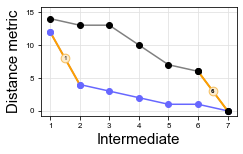

In [29]:
mks = 6
fs = 8 # table and tick labels
label_fs = 15 # axis labels
circle_fs = 6
table_fs=40
ax_fontsize=10
cbar_fontsize=10


gridlines = {"x":range(7),"y":range(0,16,5)}


graph_data(bond_plot,figure_size=(3.5,2), highlight_steps=[6], hl_only=True,
               step_labels=None, table_scale=None, gridlines=gridlines, 
               savename=None,plt_title=None)
plt.plot(mcs_distance,marker="o",markersize=mks,color=cdraw_purple,mfc=cdraw_purple,mec=cdraw_purple,zorder=0)

synthia_pink_dark = np.array([154,16,88,255])/255
for hl in [1]:
    plt.plot([hl-1,hl],mcs_distance[hl-1:hl+1],color=synthia_orange,marker="o",markersize=mks,
             mfc=cdraw_purple,mec=cdraw_purple,linewidth=2)

y_c = np.mean([mcs_distance[0],mcs_distance[1]])
plt.scatter(0.5,y_c,s=75,
                color=cdraw_orange_face,edgecolors=cdraw_orange_edge,zorder=3)

plt.annotate("1",xy=(0.5,y_c),ha="center",va="center",fontsize=circle_fs)
# plt.legend(["bond distance","MCS distance"],fontsize=fs)

#plt.savefig("../../thesis_stuff/chapter_2/baran_welwit_bond_vs_MCS.svg",bbox_inches = "tight")

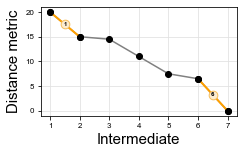

In [23]:
mks = 6
fs = 8 # table and tick labels
label_fs = 15 # axis labels
circle_fs = 6
table_fs=40
ax_fontsize=10
cbar_fontsize=10


gridlines = {"x":range(7),"y":range(0,16,5)}


graph_data(bond_plot+0.5*mcs_distance,figure_size=(3.5,2), highlight_steps=[1,6], hl_only=True,
               step_labels=None, table_scale=None, gridlines=gridlines, 
               savename=None,plt_title=None)
# plt.plot(mcs_distance,marker="o",markersize=mks,color=cdraw_purple,mfc=cdraw_purple,mec=cdraw_purple,zorder=0)

# synthia_pink_dark = np.array([154,16,88,255])/255
# for hl in [1]:
#     plt.plot([hl-1,hl],mcs_distance[hl-1:hl+1],color=synthia_orange,marker="o",markersize=mks,
#              mfc=cdraw_purple,mec=cdraw_purple,linewidth=2)

# y_c = np.mean([mcs_distance[0],mcs_distance[1]])
# plt.scatter(0.5,y_c,s=75,
#                 color=cdraw_orange_face,edgecolors=cdraw_orange_edge,zorder=3)

# plt.annotate("1",xy=(0.5,y_c),ha="center",va="center",fontsize=circle_fs)
# plt.legend(["bond distance","MCS distance"],fontsize=fs)

#plt.savefig("../../thesis_stuff/chapter_2/baran_welwit_bond_plus_MCS.svg",bbox_inches = "tight")

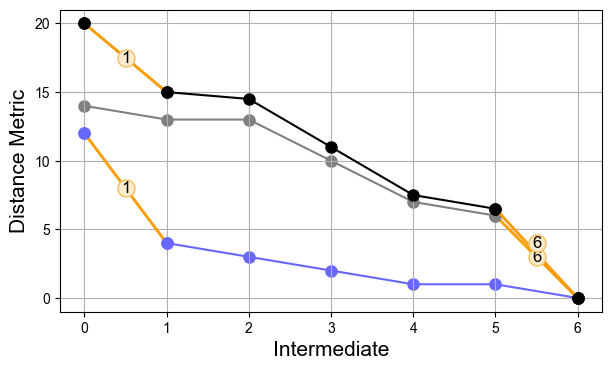

In [24]:
# Sample data loading
input_filename = "./matrices/welwitindolinone_baran.npz"
route_data = fast_process(input_filename)

amats = np.load(input_filename)["amats"]
target_atom_count = utils.get_core_atom_count(amats[-1])

bond_plot = route_data["bond_plot"]
mcs_distance = route_data["mcs_distance"]

# Plot settings
mks = 8
fs = 8  # Table and tick labels
label_fs = 15  # Axis labels
circle_fs = 12
table_fs=40
ax_fontsize = 10
cbar_fontsize=10



gridlines = {"x": range(7), "y": range(0, 21, 5)}

#graph_data(bond_plot,figure_size=(7,4), highlight_steps=[6], hl_only=True,
               #step_labels=None, table_scale=None, gridlines=gridlines, 
               #savename=None,plt_title=None)
# Initialize the plot
plt.figure(figsize=(7, 4), dpi=100)  # Adjusted figure size for better visibility

# Plot bond distance
plt.plot(bond_plot, marker="o", markersize=mks, color='gray', mfc='gray', mec='gray', label="Bond Plot", zorder=0)

# Highlight specific steps on the bond plot (6th step)
for hl in [6]:
    plt.plot([hl - 1, hl], bond_plot[hl - 1:hl + 1], color=synthia_orange, marker="o", markersize=mks,
             mfc='gray', mec='gray', linewidth=2)

y_c = np.mean([bond_plot[5], bond_plot[6]])
plt.scatter(5.5, y_c, s=150, color=cdraw_orange_face, edgecolors=cdraw_orange_edge, zorder=3)
plt.annotate("6", xy=(5.5, y_c), ha="center", va="center", fontsize=circle_fs)

# Plot MCS distance
plt.plot(mcs_distance, marker="o", markersize=mks, color=cdraw_purple, mfc=cdraw_purple, mec=cdraw_purple, label="MCS Distance", zorder=1)

# Highlight specific steps on the MCS distance plot
for hl in [1]:
    plt.plot([hl - 1, hl], mcs_distance[hl - 1:hl + 1], color=synthia_orange, marker="o", markersize=mks,
             mfc=cdraw_purple, mec=cdraw_purple, linewidth=2)

y_c = np.mean([mcs_distance[0], mcs_distance[1]])
plt.scatter(0.5, y_c, s=150, color=cdraw_orange_face, edgecolors=cdraw_orange_edge, zorder=3)
plt.annotate("1", xy=(0.5, y_c), ha="center", va="center", fontsize=circle_fs)

# Plot bond distance + 0.5 * MCS distance
plt.plot(bond_plot + 0.5 * mcs_distance, marker="o", markersize=mks, color='black', mfc='black', mec='black', label="Bond Plot + 0.5 * MCS Distance", zorder=2)

# Highlight specific steps on the bond distance + 0.5 * MCS distance plot (1st and 6th steps)
for hl in [1, 6]:
    plt.plot([hl - 1, hl], (bond_plot + 0.5 * mcs_distance)[hl - 1:hl + 1], color=synthia_orange, marker="o", markersize=mks,
             mfc='black', mec='black', linewidth=2)

    
# Annotate the highlighted steps in the third plot
y_c1 = np.mean([(bond_plot + 0.5 * mcs_distance)[0], (bond_plot + 0.5 * mcs_distance)[1]])
plt.scatter(0.5, y_c1, s=150, color=cdraw_orange_face, edgecolors=cdraw_orange_edge, zorder=3)
plt.annotate("1", xy=(0.5, y_c1), ha="center", va="center", fontsize=circle_fs)

y_c6 = np.mean([(bond_plot + 0.5 * mcs_distance)[5], (bond_plot + 0.5 * mcs_distance)[6]])
plt.scatter(5.5, 4, s=150, color=cdraw_orange_face, edgecolors=cdraw_orange_edge, zorder=3)
plt.annotate("6", xy=(5.5, 4), ha="center", va="center", fontsize=circle_fs)

# Gridlines and labels
plt.grid(True)
plt.xticks(gridlines["x"], fontsize=ax_fontsize)
plt.yticks(gridlines["y"], fontsize=ax_fontsize)
plt.xlabel('Intermediate', fontsize=label_fs)
plt.ylabel('Distance Metric', fontsize=label_fs)

# Add legend
#plt.legend(fontsize=fs)

# Display the plot
plt.show()


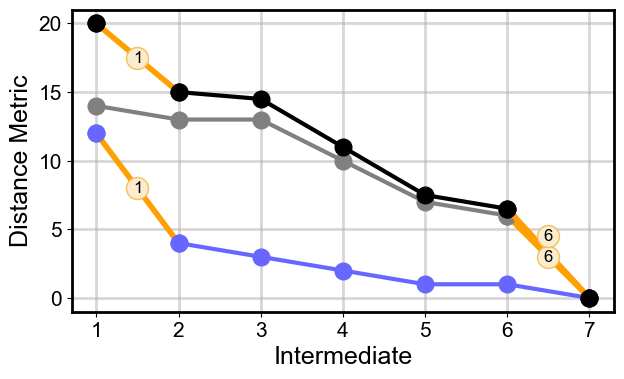

In [25]:
# Sample data loading
input_filename = "./matrices/welwitindolinone_baran.npz"
route_data = fast_process(input_filename)

amats = np.load(input_filename)["amats"]
target_atom_count = utils.get_core_atom_count(amats[-1])

bond_plot = route_data["bond_plot"]
mcs_distance = route_data["mcs_distance"]

# Plot settings
mks = 12
fs = 10  # Table and tick labels
label_fs = 18  # Axis labels
circle_fs = 12
table_fs = 40
ax_fontsize = 15
cbar_fontsize = 15

gridlines = {"x": range(7), "y": range(0, 21, 5)}

# Initialize the plot
plt.figure(figsize=(7, 4), dpi=100)  # Adjusted figure size for better visibility

# Plot bond distance
plt.plot(range(1, len(bond_plot) + 1), bond_plot, marker="o", markersize=mks, color='gray', mfc='gray', mec='gray', label="Bond Plot", zorder=2, linewidth=3)

# Highlight specific steps on the bond plot (6th step)
for hl in [6]:
    plt.plot([hl, hl + 1], bond_plot[hl - 1:hl + 1], color=synthia_orange, marker="o", markersize=mks,
             mfc='gray', mec='gray', linewidth=4)

y_c = np.mean([bond_plot[5], bond_plot[6]])
plt.scatter(6.5, y_c, s=250, color=cdraw_orange_face, edgecolors=cdraw_orange_edge, zorder=3)
plt.annotate("6", xy=(6.5, y_c), ha="center", va="center", fontsize=circle_fs)

# Plot MCS distance
plt.plot(range(1, len(mcs_distance) + 1), mcs_distance, marker="o", markersize=mks, color=cdraw_purple, mfc=cdraw_purple, mec=cdraw_purple, label="MCS Distance", zorder=2, linewidth=3)

# Highlight specific steps on the MCS distance plot
for hl in [1]:
    plt.plot([hl, hl + 1], mcs_distance[hl - 1:hl + 1], color=synthia_orange, marker="o", markersize=mks,
             mfc=cdraw_purple, mec=cdraw_purple, linewidth=4)

y_c = np.mean([mcs_distance[0], mcs_distance[1]])
plt.scatter(1.5, y_c, s=250, color=cdraw_orange_face, edgecolors=cdraw_orange_edge, zorder=3)
plt.annotate("1", xy=(1.5, y_c), ha="center", va="center", fontsize=circle_fs)

# Plot bond distance + 0.5 * MCS distance
plt.plot(range(1, len(bond_plot) + 1), bond_plot + 0.5 * mcs_distance, marker="o", markersize=mks, color='black', mfc='black', mec='black', label="Bond Plot + 0.5 * MCS Distance", zorder=2, linewidth=3)  # Set alpha value for transparency

# Highlight specific steps on the bond distance + 0.5 * MCS distance plot (1st and 6th steps)
for hl in [1, 6]:
    plt.plot([hl, hl + 1], (bond_plot + 0.5 * mcs_distance)[hl - 1:hl + 1], color=synthia_orange, marker="o", markersize=mks,
             mfc='black', mec='black', linewidth=4)

# Annotate the highlighted steps in the third plot
y_c1 = np.mean([(bond_plot + 0.5 * mcs_distance)[0], (bond_plot + 0.5 * mcs_distance)[1]])
plt.scatter(1.5, y_c1, s=250, color=cdraw_orange_face, edgecolors=cdraw_orange_edge, zorder=3)
plt.annotate("1", xy=(1.5, y_c1), ha="center", va="center", fontsize=circle_fs)

y_c6 = np.mean([(bond_plot + 0.5 * mcs_distance)[5], (bond_plot + 0.5 * mcs_distance)[6]])
plt.scatter(6.5, 4.5, s=250, color=cdraw_orange_face, edgecolors=cdraw_orange_edge, zorder=3)
plt.annotate("6", xy=(6.5, 4.5), ha="center", va="center", fontsize=circle_fs)

# Gridlines and labels
plt.grid(True, linewidth=2, alpha=0.5)  # Adjusted frame edge thickness and transparency
plt.xticks(list(range(1, len(bond_plot) + 1)), fontsize=ax_fontsize)
plt.yticks(gridlines["y"], fontsize=ax_fontsize)
plt.xlabel('Intermediate', fontsize=label_fs)
plt.ylabel('Distance Metric', fontsize=label_fs)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)  # Adjust the thickness as needed

# Add legend
#plt.legend(fontsize=fs)

# Display the plot
plt.show()


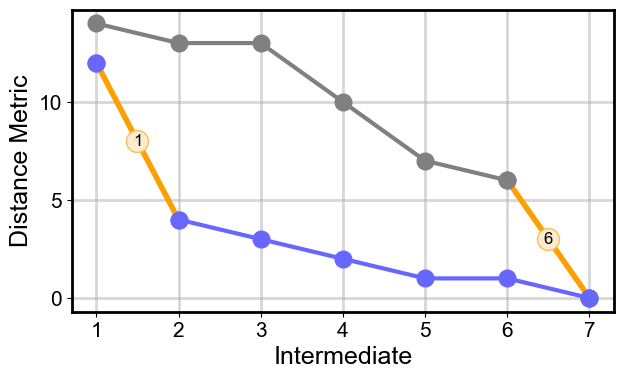

In [33]:
# Sample data loading
input_filename = "./matrices/welwitindolinone_baran.npz"
route_data = fast_process(input_filename)

amats = np.load(input_filename)["amats"]
target_atom_count = utils.get_core_atom_count(amats[-1])

bond_plot = route_data["bond_plot"]
mcs_distance = route_data["mcs_distance"]

# Plot settings
mks = 12
fs = 10  # Table and tick labels
label_fs = 18  # Axis labels
circle_fs = 12
table_fs = 40
ax_fontsize = 15
cbar_fontsize = 15

gridlines = {"x": range(7), "y": range(0, 15, 5)}

# Initialize the plot
plt.figure(figsize=(7, 4), dpi=100)  # Adjusted figure size for better visibility

# Plot bond distance
plt.plot(range(1, len(bond_plot) + 1), bond_plot, marker="o", markersize=mks, color='gray', mfc='gray', mec='gray', label="Bond Plot", zorder=2, linewidth=3)

# Highlight specific steps on the bond plot (6th step)
for hl in [6]:
    plt.plot([hl, hl + 1], bond_plot[hl - 1:hl + 1], color=synthia_orange, marker="o", markersize=mks,
             mfc='gray', mec='gray', linewidth=4)

y_c = np.mean([bond_plot[5], bond_plot[6]])
plt.scatter(6.5, y_c, s=250, color=cdraw_orange_face, edgecolors=cdraw_orange_edge, zorder=3)
plt.annotate("6", xy=(6.5, y_c), ha="center", va="center", fontsize=circle_fs)

# Plot MCS distance
plt.plot(range(1, len(mcs_distance) + 1), mcs_distance, marker="o", markersize=mks, color=cdraw_purple, mfc=cdraw_purple, mec=cdraw_purple, label="MCS Distance", zorder=2, linewidth=3)

# Highlight specific steps on the MCS distance plot
for hl in [1]:
    plt.plot([hl, hl + 1], mcs_distance[hl - 1:hl + 1], color=synthia_orange, marker="o", markersize=mks,
             mfc=cdraw_purple, mec=cdraw_purple, linewidth=4)

y_c = np.mean([mcs_distance[0], mcs_distance[1]])
plt.scatter(1.5, y_c, s=250, color=cdraw_orange_face, edgecolors=cdraw_orange_edge, zorder=3)
plt.annotate("1", xy=(1.5, y_c), ha="center", va="center", fontsize=circle_fs)

# Gridlines and labels
plt.grid(True, linewidth=2, alpha=0.5)  # Adjusted frame edge thickness and transparency
plt.xticks(list(range(1, len(bond_plot) + 1)), fontsize=ax_fontsize)
plt.yticks(gridlines["y"], fontsize=ax_fontsize)
plt.xlabel('Intermediate', fontsize=label_fs)
plt.ylabel('Distance Metric', fontsize=label_fs)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)  # Adjust the thickness as needed

# Add legend
#plt.legend(fontsize=fs)

# Display the plot
plt.show()


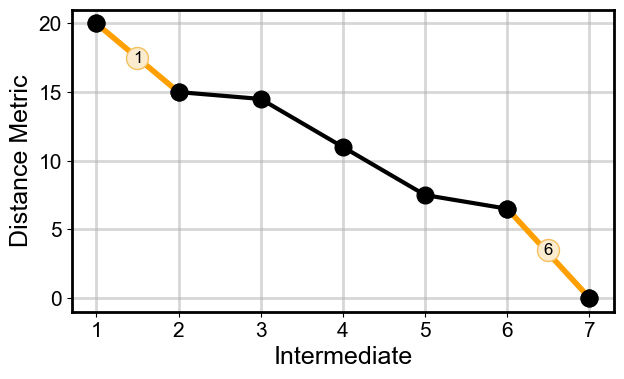

In [35]:
# Sample data loading
input_filename = "./matrices/welwitindolinone_baran.npz"
route_data = fast_process(input_filename)

amats = np.load(input_filename)["amats"]
target_atom_count = utils.get_core_atom_count(amats[-1])

bond_plot = route_data["bond_plot"]
mcs_distance = route_data["mcs_distance"]

# Plot settings
mks = 12
fs = 10  # Table and tick labels
label_fs = 18  # Axis labels
circle_fs = 12
table_fs = 40
ax_fontsize = 15
cbar_fontsize = 15

gridlines = {"x": range(7), "y": range(0, 21, 5)}

# Initialize the plot
plt.figure(figsize=(7, 4), dpi=100)  # Adjusted figure size for better visibility

# Plot bond distance + 0.5 * MCS distance
plt.plot(range(1, len(bond_plot) + 1), bond_plot + 0.5 * mcs_distance, marker="o", markersize=mks, color='black', mfc='black', mec='black', label="Bond Plot + 0.5 * MCS Distance", zorder=2, linewidth=3)  # Set alpha value for transparency

# Highlight specific steps on the bond distance + 0.5 * MCS distance plot (1st and 6th steps)
for hl in [1, 6]:
    plt.plot([hl, hl + 1], (bond_plot + 0.5 * mcs_distance)[hl - 1:hl + 1], color=synthia_orange, marker="o", markersize=mks,
             mfc='black', mec='black', linewidth=4)

# Annotate the highlighted steps in the third plot
y_c1 = np.mean([(bond_plot + 0.5 * mcs_distance)[0], (bond_plot + 0.5 * mcs_distance)[1]])
plt.scatter(1.5, y_c1, s=250, color=cdraw_orange_face, edgecolors=cdraw_orange_edge, zorder=3)
plt.annotate("1", xy=(1.5, y_c1), ha="center", va="center", fontsize=circle_fs)

y_c6 = np.mean([(bond_plot + 0.5 * mcs_distance)[5], (bond_plot + 0.5 * mcs_distance)[6]])
plt.scatter(6.5, 3.5, s=250, color=cdraw_orange_face, edgecolors=cdraw_orange_edge, zorder=3)
plt.annotate("6", xy=(6.5, 3.5), ha="center", va="center", fontsize=circle_fs)

# Gridlines and labels
plt.grid(True, linewidth=2, alpha=0.5)  # Adjusted frame edge thickness and transparency
plt.xticks(list(range(1, len(bond_plot) + 1)), fontsize=ax_fontsize)
plt.yticks(gridlines["y"], fontsize=ax_fontsize)
plt.xlabel('Intermediate', fontsize=label_fs)
plt.ylabel('Distance Metric', fontsize=label_fs)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)  # Adjust the thickness as needed

# Add legend
#plt.legend(fontsize=fs)

# Display the plot
plt.show()
